# Milestone 1

The objective of this project is to analyze the modelled daily rainfall dataset over NSW, Australia, spanning 1889- 2014. The dataset can be found [here](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681). 

### Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import dask
import dask.dataframe as dd
import seaborn as sns
import altair as alt

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### Variables

In [3]:
# Figshare article metadata
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall"

### 3. Send API request to Figshare to download rainfall data 

We will download the data from [figshare](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681) using [figshare API](https://docs.figshare.com/).

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # articles data
files = data["files"]             # list of files
files[3] # target file (data.zip)

{'id': 26766812,
 'name': 'data.zip',
 'size': 814041183,
 'is_link_only': False,
 'download_url': 'https://ndownloader.figshare.com/files/26766812',
 'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
 'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9'}

### Collect data.zip folder from the list of `files` 

In [5]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        # Download data.zip
        urlretrieve(file["download_url"], os.path.join(output_directory, file["name"]))

CPU times: total: 17.1 s
Wall time: 3min 18s


### Unzip files from `data.zip` folder

In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(os.path.join(output_directory, "data"))

CPU times: total: 1min 9s
Wall time: 1min 15s


### 4. Combining csv's in `data` folder

In [9]:
%%time
## merging files
files = glob.glob(os.path.join(output_directory, "data", "*.csv"))
# Exclude observed_daily_rainfall from our analysis
files = [file for file in files if file != os.path.join(output_directory, "data", "observed_daily_rainfall_SYD.csv")]
df = pd.concat((pd.read_csv(file, index_col=0) 
                .assign(model=re.findall(r'[^\/(\\)]+(?=\_daily_rainfall_NSW.csv)', file)[0])
                for file in files)
              )
df.to_csv(os.path.join(output_directory, "combined_data.csv"))

CPU times: total: 10min 25s
Wall time: 11min 12s


| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |    11 min 12s  |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

In [10]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.7G	figsharerainfall/combined_data.csv


In [11]:
print(df.shape)

(62467843, 6)


In [12]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


### 5. Load the combined CSV to memory and perform a simple EDA

#### Combined Approach #1 & Approach # 2
_Loading only required columns and also change dtype of column `rain (mm/day)` while reading csv to reduce memory usage_

In [13]:
%%time
use_cols = ['rain (mm/day)', 'time']
df = pd.read_csv(os.path.join(output_directory, "combined_data.csv"), usecols=use_cols, index_col=False, 
                 dtype={'rain (mm/day)':'float32'})

CPU times: total: 1min 11s
Wall time: 1min 22s


In [14]:
# Memory usage
print(f"Memory usage with float32: {df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float32: 749.61 MB


In [15]:
%%time
df['month'] = pd.to_datetime(df['time']).dt.month
df = df.groupby(['month'], as_index=False).agg({'rain (mm/day)':'mean'})

CPU times: total: 55.3 s
Wall time: 1min 1s


CPU times: total: 156 ms
Wall time: 303 ms


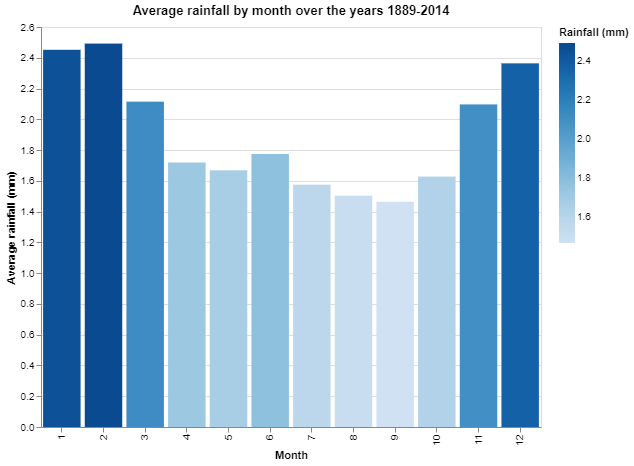

In [16]:
%%time
(alt.Chart(df, title='Average rainfall by month over the years 1889-2014')
    .encode(x=alt.X('month:O', title='Month'), 
            y=alt.Y('rain (mm/day)', title='Average rainfall (mm)'), 
            color=alt.Color('rain (mm/day)', title='Rainfall (mm)')).mark_bar()).properties(width=500, height=400)

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   2 mins   |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

#### Approach #2

Next, we will use [Dask](https://dask.org/) to load our data and do some simple aggregation.

In [17]:
%%time
# Read csv as Dask dataframe
ddf = dd.read_csv('figsharerainfall/combined_data.csv', usecols=use_cols, parse_dates=["time"])

CPU times: total: 141 ms
Wall time: 271 ms


In [18]:
%%time
ddf['month'] = ddf['time'].dt.month
ddf = ddf.groupby(['month']).agg({'rain (mm/day)':'mean'}).compute()
ddf = ddf.reset_index()

CPU times: total: 2min 23s
Wall time: 1min 18s


CPU times: total: 31.2 ms
Wall time: 32.5 ms


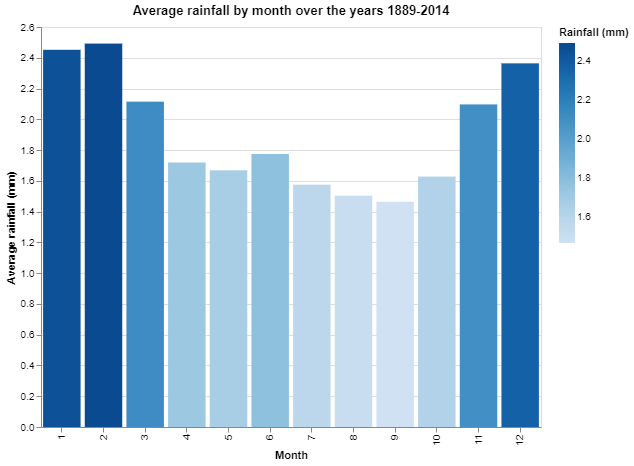

In [19]:
%%time
(alt.Chart(ddf, title='Average rainfall by month over the years 1889-2014')
    .encode(x=alt.X('month:O', title='Month'), 
            y=alt.Y('rain (mm/day)', title='Average rainfall (mm)'), 
            color=alt.Color('rain (mm/day)', title='Rainfall (mm)')).mark_bar()).properties(width=500, height=400)

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   1 min 30 s   |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |

### 6. Perform a simple EDA in R

#### Approach to transfer the dataframe from python to R

In [20]:
%load_ext rpy2.ipython

C:\Users\hp\miniconda3\envs\525_2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Time difference of 1.135065 secs


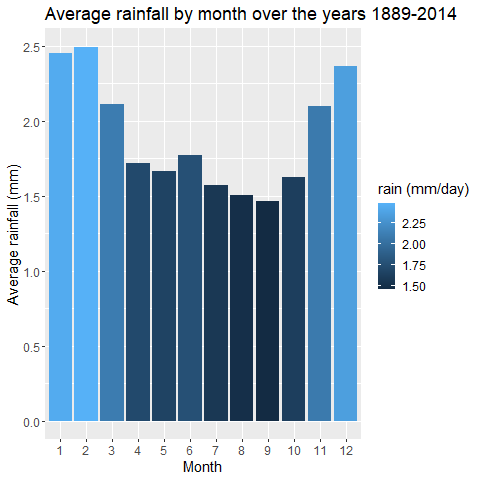

CPU times: total: 1.38 s
Wall time: 1.64 s


In [21]:
%%time
%%R -i df
start_time <- Sys.time()
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
p <- ggplot(df, aes(x=as.factor(month), y=`rain (mm/day)`, fill=`rain (mm/day)`)) +
     geom_bar(stat='identity') +
     labs(x = 'Month', y='Average rainfall (mm)', title='Average rainfall by month over the years 1889-2014') +
    theme(text=element_text(size=15))
    
end_time <- Sys.time()
print(p)
print(end_time - start_time)

#### Discuss why you chose this approach over others

_Used `arrow exchange` over other three methods (Parquet file, Feather file, Pandas exchange) as we have already selected desired columns and carried out wrangling for EDA in pandas dataframe. So, it made more sense to use arrow exchange instead of having csv read as parquet or feather file and again do same wrangling._

#### Summary of results

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   1.13 secs  |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |            |
| Nagraj Rao        |                  |      |           |        |            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |            |